In [1]:
#Importing required modules
import random
import numpy as np
import pandas as pd
import itertools
import seaborn as sns
import matplotlib.pyplot as plt
from deap import base, creator, tools
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

In [2]:
# Load the dataset from the CSV file
df = pd.read_csv('predictive_maintenance.csv')

In [3]:
# Display the first few rows of the dataset to verify loading
print(df.head())

   UDI Product ID Type  Air temperature [K]  Process temperature [K]  \
0    1     M14860    M                298.1                    308.6   
1    2     L47181    L                298.2                    308.7   
2    3     L47182    L                298.1                    308.5   
3    4     L47183    L                298.2                    308.6   
4    5     L47184    L                298.2                    308.7   

   Rotational speed [rpm]  Torque [Nm]  Vibration Levels   Operational Hours  \
0                    1551         42.8               42.0               20.0   
1                    1408         46.3               52.0               21.0   
2                    1498         49.4               44.0               18.0   
3                    1433         39.5               52.0               10.0   
4                    1408         40.0               44.0               10.0   

  Failure Type  
0   No Failure  
1   No Failure  
2   No Failure  
3   No Failure  
4

In [4]:
#Display the informations about the features in the dataset
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   UDI                      500 non-null    int64  
 1   Product ID               500 non-null    object 
 2   Type                     500 non-null    object 
 3   Air temperature [K]      500 non-null    float64
 4   Process temperature [K]  500 non-null    float64
 5   Rotational speed [rpm]   500 non-null    int64  
 6   Torque [Nm]              500 non-null    float64
 7   Vibration Levels         500 non-null    float64
 8   Operational Hours        500 non-null    float64
 9   Failure Type             500 non-null    object 
dtypes: float64(5), int64(2), object(3)
memory usage: 39.2+ KB
None


In [5]:
#Selecting relevant features for the predictive maintenance problem
features = df[['Air temperature [K]', 'Process temperature [K]', 
                'Rotational speed [rpm]', 'Torque [Nm]', 
                'Vibration Levels ', 'Operational Hours']]
target = df['Failure Type']  # Change 'Failure Type' based on your dataset's target column

#Encoding target variable (0 for No Failure, 1 for Failure)
target_encoded = target.map(lambda x: 0 if x == 'No Failure' else 1)

# Split the dataset
X = features
y = target_encoded
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [6]:
#Genetic Algorithm Parameters
NGEN = 50  # Maximum generations
MUTPB = 0.2  # Mutation probability
CROSSPB = 0.5  # Crossover probability
STALL_GENERATIONS = 10  # Number of generations to check for no improvement
SATISFACTORY_FITNESS = 0.95  # Threshold for satisfactory fitness

In [7]:
#Setup DEAP Framework
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

toolbox = base.Toolbox()
toolbox.register("attr_bool", random.randint, 0, 1)
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_bool, n=X_train.shape[1])
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

# Define the evaluation function
def evaluate(individual):
    selected_features = [index for index, value in enumerate(individual) if value == 1]
    
    if len(selected_features) == 0:
        return (0,)  # Return 0 if no features are selected

    model = RandomForestClassifier(random_state=42)
    model.fit(X_train.iloc[:, selected_features], y_train)
    predictions = model.predict(X_test.iloc[:, selected_features])
    accuracy = accuracy_score(y_test, predictions)
    return (accuracy,)

toolbox.register("evaluate", evaluate)
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutFlipBit, indpb=MUTPB)  # Change 'flip_prob' to 'indpb'
toolbox.register("select", tools.selTournament, tournsize=3)

In [8]:
#Visualization Functions
def plot_fitness_over_generations(fitness_values):
    plt.figure(figsize=(10, 5))
    plt.plot(fitness_values, marker='o')
    plt.title('Best Fitness Over Generations')
    plt.xlabel('Generation')
    plt.ylabel('Best Fitness')
    plt.grid()
    plt.show()
def plot_feature_selection(best_individual, feature_names):
    selected_features = [feature_names[i] for i in range(len(best_individual)) if best_individual[i] == 1]
    plt.figure(figsize=(10, 5))
    plt.bar(selected_features, [1] * len(selected_features))
    plt.title('Selected Features by Genetic Algorithm')
    plt.ylabel('Selected (1) or Not Selected (0)')
    plt.ylim(0, 1.5)
    plt.grid(axis='y')

Starting the genetic algorithm...
-- Generation 0 --
Best Fitness: 0.87
Best Individual of Generation 0: [1, 0, 1, 1, 1, 0], Fitness: 0.87
Selected Features: ['Air temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]', 'Vibration Levels ']
-- Generation 1 --
Best Fitness: 0.87
Best Individual of Generation 1: [0, 1, 1, 1, 0, 1], Fitness: 0.87
Selected Features: ['Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]', 'Operational Hours']
-- Generation 2 --
Best Fitness: 0.87
Best Individual of Generation 2: [0, 1, 1, 1, 0, 1], Fitness: 0.87
Selected Features: ['Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]', 'Operational Hours']
-- Generation 3 --
Best Fitness: 0.87
Best Individual of Generation 3: [1, 0, 1, 1, 0, 1], Fitness: 0.87
Selected Features: ['Air temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]', 'Operational Hours']
-- Generation 4 --
Best Fitness: 0.87
Best Individual of Generation 4: [0, 1, 1, 1, 0, 1], Fitness: 0.87
Selected Feat

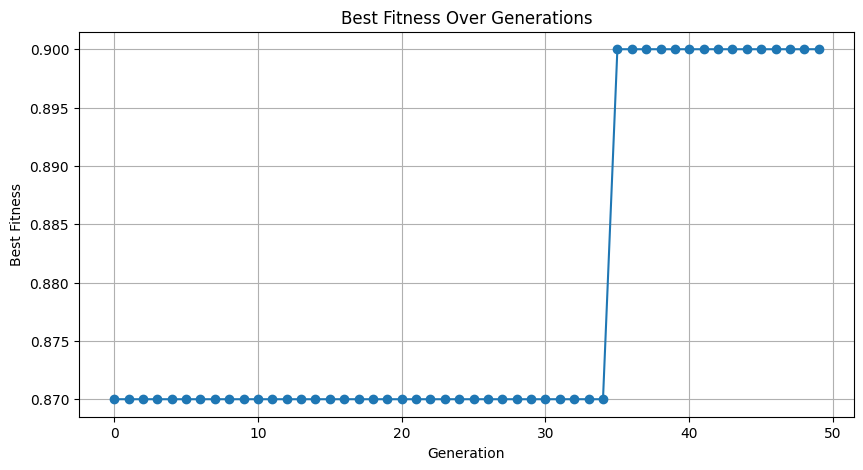

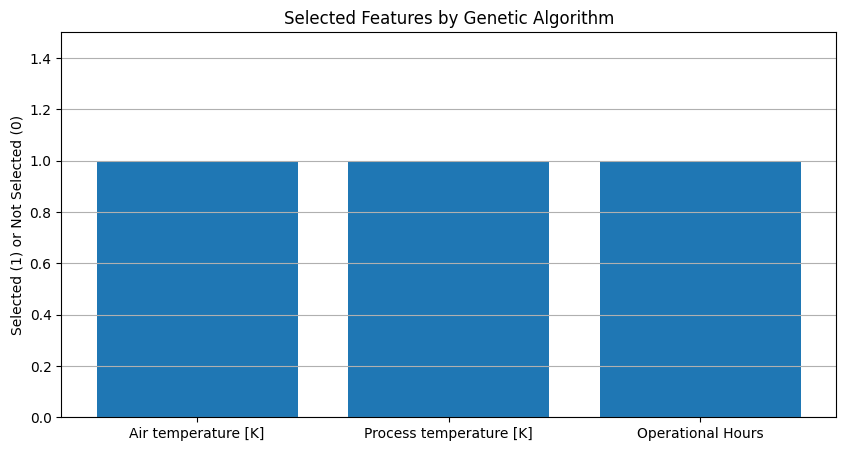

In [9]:
#Defining the main function for generation of feature sets
def main():
    random.seed(42)
    # Create initial population
    population = toolbox.population(n=50)

    best_fitness = -np.inf
    stall_count = 0
    fitness_values = []  
    best_individual = None  

    print("Starting the genetic algorithm...")

    for gen in range(NGEN):
        print(f"-- Generation {gen} --")
        
        # Evaluate fitness of individuals
        fitnesses = list(map(toolbox.evaluate, population))
        for ind, fit in zip(population, fitnesses):
            ind.fitness.values = fit

        # Extract the fitness values from the tuple
        max_fitness = max(fit[0] for fit in fitnesses)  # Get the best fitness score
        fitness_values.append(max_fitness)  # Store the best fitness value
        print(f"Best Fitness: {max_fitness}")

        # Get the best individual based on fitness
        best_individual = max(population, key=lambda ind: ind.fitness.values[0])
        best_fitness = best_individual.fitness.values[0]

        # Print details of the best individual in the current generation
        selected_features = [X.columns[i] for i in range(len(best_individual)) if best_individual[i] == 1]  # Assuming 1 indicates selected features
        print(f"Best Individual of Generation {gen}: {best_individual}, Fitness: {best_fitness}")
        print(f"Selected Features: {selected_features}")

        # Check stall count and early stopping conditions
        if stall_count >= STALL_GENERATIONS:
            print("Stopping early due to no fitness improvement.")
            break
        
        if best_fitness >= SATISFACTORY_FITNESS:
            print("Stopping early due to satisfactory fitness level.")
            break

        # Create the next generation
        offspring = toolbox.select(population, len(population))
        offspring = list(map(toolbox.clone, offspring))

        for child1, child2 in zip(offspring[::2], offspring[1::2]):
            if random.random() < CROSSPB:
                toolbox.mate(child1, child2)
                del child1.fitness.values
                del child2.fitness.values

        for mutant in offspring:
            if random.random() < MUTPB:
                toolbox.mutate(mutant)
                del mutant.fitness.values

        # Evaluate the individuals with an invalid fitness
        invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
        fitnesses = list(map(toolbox.evaluate, invalid_ind))
        for ind, fit in zip(invalid_ind, fitnesses):
            ind.fitness.values = fit

        # Replace the old population by the offspring
        population[:] = offspring

    print("Genetic algorithm completed.")

    # Plot the fitness over generations
    plot_fitness_over_generations(fitness_values)

    # Plot the feature selection of the best individual
    plot_feature_selection(best_individual, X.columns)

#Run the main function
if __name__ == "__main__":
    main() 